# Requirements

In [1]:
import cv2
import os
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
from typing import Tuple, List

# Median Filter From Scratch

In [2]:
def median_filter(img: np.ndarray, point_xy: np.ndarray, filter_size: int) -> List[float]:
    x_coord, y_coord = int(point_xy[0]), int(point_xy[1])
    half_size = filter_size // 2

    min_row_calc = y_coord - half_size
    max_row_calc_exclusive = y_coord + half_size + 1
    min_col_calc = x_coord - half_size
    max_col_calc_exclusive = x_coord + half_size + 1

    min_row_clipped = max(0, min_row_calc)
    max_row_clipped_exclusive = min(img.shape[0], max_row_calc_exclusive)
    min_col_clipped = max(0, min_col_calc)
    max_col_clipped_exclusive = min(img.shape[1], max_col_calc_exclusive)

    if min_row_clipped >= max_row_clipped_exclusive or min_col_clipped >= max_col_clipped_exclusive:
        return img[y_coord, x_coord].tolist() if img.ndim == 3 and img.shape[2] > 1 else [img[y_coord, x_coord]]

    num_channels = img.shape[2] if img.ndim == 3 else 1
    channel_pixel_lists = [[] for _ in range(num_channels)]

    neighborhood = img[min_row_clipped:max_row_clipped_exclusive, min_col_clipped:max_col_clipped_exclusive]

    if num_channels > 1:
        for i in range(num_channels):
            channel_pixel_lists[i].extend(neighborhood[:, :, i].flatten())
    else:
        channel_pixel_lists[0].extend(neighborhood.flatten())

    median_pixel_values = []
    for i in range(num_channels):
        if channel_pixel_lists[i]:
            median_pixel_values.append(np.median(channel_pixel_lists[i]))
        else: 
            current_pixel_val = img[y_coord, x_coord, i] if num_channels > 1 else img[y_coord, x_coord]
            median_pixel_values.append(current_pixel_val)

    return median_pixel_values



In [3]:
def edge_median_filter(img_hsv: np.ndarray, contours_list: tuple, filter_size: int = 7) -> np.ndarray:
    temp_img_hsv = np.copy(img_hsv) 

    for partition in contours_list:
        for point_contour_wrapper in partition: 
            point_xy = point_contour_wrapper[0] 

            median_values = median_filter(img_hsv, point_xy, filter_size)
            temp_img_hsv[point_xy[1], point_xy[0]] = median_values 

    return cv2.cvtColor(temp_img_hsv, cv2.COLOR_HSV2BGR)


In [4]:
def display_region(
    org_image: np.ndarray,
    shadow_clear_image: np.ndarray,
    label_id: int, 
    label_region_mask: np.ndarray,
    contours: tuple,
) -> None:
    reverse_mask_single_channel = cv2.bitwise_not(label_region_mask) # TODO
    
    img_w_hole = cv2.bitwise_and(org_image, org_image, mask=reverse_mask_single_channel) # TODO

    temp_filter_bgr_display = cv2.cvtColor(label_region_mask, cv2.COLOR_GRAY2BGR) # TODO
    
    cv2.drawContours(temp_filter_bgr_display, contours, -1, (255, 0, 0), 3)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax = axes.ravel()
    plt.suptitle(f"Shadow Region {label_id} Processing", fontsize=16)

    ax[0].imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
    ax[0].axis("off"); ax[0].set_title("Original Image")

    ax[1].imshow(cv2.cvtColor(temp_filter_bgr_display, cv2.COLOR_BGR2RGB)) 
    ax[1].axis("off"); ax[1].set_title("Identified Shadow Region (Contour)")

    ax[2].imshow(cv2.cvtColor(img_w_hole, cv2.COLOR_BGR2RGB))
    ax[2].axis("off"); ax[2].set_title("Original with Shadow Cut")

    ax[3].imshow(cv2.cvtColor(shadow_clear_image, cv2.COLOR_BGR2RGB))
    ax[3].axis("off"); ax[3].set_title("Corrected Image (Current State)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [5]:

def correct_region_lab(
    lab_img_stats_source: np.ndarray, 
    shadow_clear_img_bgr_to_modify: np.ndarray, 
    shadow_indices: np.ndarray,
    non_shadow_indices: np.ndarray,
) -> np.ndarray:
    shadow_average_lab = np.mean(
        lab_img_stats_source[shadow_indices[0], shadow_indices[1], :], axis=0
    ) 
    shadow_average_lab = np.maximum(shadow_average_lab, 1e-6) 

    border_average_lab = np.mean(
        lab_img_stats_source[non_shadow_indices[0], non_shadow_indices[1], :], axis=0
    ) 
    border_average_lab = np.maximum(border_average_lab, 1e-6)

    lab_ratio = border_average_lab / shadow_average_lab

    shadow_clear_lab_temp = cv2.cvtColor(shadow_clear_img_bgr_to_modify, cv2.COLOR_BGR2LAB)
    
    current_shadow_pixels_lab = shadow_clear_lab_temp[shadow_indices[0], shadow_indices[1]].astype(np.float32)
    
    corrected_shadow_pixels_lab = current_shadow_pixels_lab * lab_ratio
    
    corrected_shadow_pixels_lab = np.clip(corrected_shadow_pixels_lab, 0, 255)

    shadow_clear_lab_temp[shadow_indices[0], shadow_indices[1]] = corrected_shadow_pixels_lab.astype(np.uint8)
    
    shadow_clear_img_corrected_bgr = cv2.cvtColor(shadow_clear_lab_temp, cv2.COLOR_LAB2BGR)

    return shadow_clear_img_corrected_bgr




In [6]:
def correct_region_bgr(
    org_img_bgr_stats_source: np.ndarray, 
    shadow_clear_img_bgr_to_modify: np.ndarray, 
    shadow_indices: np.ndarray,
    non_shadow_indices: np.ndarray,
) -> np.ndarray:
    shadow_average_bgr = np.mean(
        org_img_bgr_stats_source[shadow_indices[0], shadow_indices[1], :], axis=0
    )
    shadow_average_bgr = np.maximum(shadow_average_bgr, 1e-6)

    border_average_bgr = np.mean(
        org_img_bgr_stats_source[non_shadow_indices[0], non_shadow_indices[1], :], axis=0
    )
    border_average_bgr = np.maximum(border_average_bgr, 1e-6)
    
    bgr_ratio = border_average_bgr / shadow_average_bgr

    current_shadow_pixels_bgr = shadow_clear_img_bgr_to_modify[shadow_indices[0], shadow_indices[1]].astype(np.float32)
    
    corrected_shadow_pixels_bgr = current_shadow_pixels_bgr * bgr_ratio
    corrected_shadow_pixels_bgr = np.clip(corrected_shadow_pixels_bgr, 0, 255)

    shadow_clear_img_bgr_to_modify[shadow_indices[0], shadow_indices[1]] = corrected_shadow_pixels_bgr.astype(np.uint8)

    return shadow_clear_img_bgr_to_modify


In [7]:

def process_regions(
    org_image: np.ndarray, 
    mask_single_channel: np.ndarray,
    lab_adjustment: bool,
    shadow_dilation_kernel_size: int,
    shadow_dilation_iteration: int,
    shadow_size_threshold: int,
    verbose: bool,
) -> np.ndarray:
    lab_img_source_stats = cv2.cvtColor(org_image, cv2.COLOR_BGR2LAB) 
    shadow_clear_img_accumulator = np.copy(org_image) 

    labels = measure.label(mask_single_channel)

    non_shadow_kernel_size_tuple = (shadow_dilation_kernel_size, shadow_dilation_kernel_size)
    non_shadow_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, non_shadow_kernel_size_tuple)

    CHANNEL_MAX_UINT8 = 255

    for label_value in np.unique(labels):
        if label_value == 0:
            continue
        
        current_region_mask = np.zeros(mask_single_channel.shape, dtype="uint8")
        current_region_mask[labels == label_value] = CHANNEL_MAX_UINT8

        if cv2.countNonZero(current_region_mask) >= shadow_size_threshold:
            shadow_indices = np.where(current_region_mask == CHANNEL_MAX_UINT8)

            dilated_mask_for_border = cv2.dilate(
                current_region_mask, non_shadow_kernel, iterations=shadow_dilation_iteration
            )
            border_mask = cv2.bitwise_xor(dilated_mask_for_border, current_region_mask)
            non_shadow_indices = np.where(border_mask == CHANNEL_MAX_UINT8)

            if non_shadow_indices[0].size == 0: 
                continue

            contours, _ = cv2.findContours(current_region_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            if lab_adjustment:
                shadow_clear_img_accumulator = correct_region_lab(
                    lab_img_source_stats, shadow_clear_img_accumulator, shadow_indices, non_shadow_indices
                )
            else:
                shadow_clear_img_accumulator = correct_region_bgr(
                    org_image, shadow_clear_img_accumulator, shadow_indices, non_shadow_indices
                )
            
            image_hsv_for_filter = cv2.cvtColor(shadow_clear_img_accumulator, cv2.COLOR_BGR2HSV)
            shadow_clear_img_accumulator = edge_median_filter(image_hsv_for_filter, contours)

            if verbose:
                display_region(org_image, shadow_clear_img_accumulator, label_value, current_region_mask, contours)

    return shadow_clear_img_accumulator



In [8]:
def calculate_mask(
    org_image: np.ndarray, ab_threshold_param: int, region_adjustment_kernel_size: int
) -> np.ndarray:
    lab_img = cv2.cvtColor(org_image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_img)

    mean_l = np.mean(l_channel)
    std_l = np.std(l_channel)
    mean_b = np.mean(b_channel)
    std_b = np.std(b_channel)

    threshold_l_val = mean_l - (std_l / 3.0)
    threshold_b_val = mean_b - (std_b / 3.0) 

    _, mask_l = cv2.threshold(l_channel, int(threshold_l_val), 255, cv2.THRESH_BINARY_INV)
    
    final_mask = mask_l
    if ab_threshold_param < 50:
        
        _, mask_b = cv2.threshold(b_channel, int(threshold_b_val), 255, cv2.THRESH_BINARY_INV)
        final_mask = cv2.bitwise_and(mask_l, mask_b)

    kernel_size_tuple = (region_adjustment_kernel_size, region_adjustment_kernel_size)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size_tuple)
    
    morphed_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel)

    return morphed_mask



In [9]:
def remove_shadows(
    org_image: np.ndarray,
    ab_threshold: int,
    lab_adjustment: bool,
    region_adjustment_kernel_size: int,
    shadow_dilation_iteration: int,
    shadow_dilation_kernel_size: int,
    shadow_size_threshold: int,
    verbose: bool,
) -> Tuple[np.ndarray, np.ndarray]:
    
    mask_single_channel = calculate_mask(
        org_image, ab_threshold, region_adjustment_kernel_size
    )
    
    shadow_clear_img_result_bgr = process_regions(
        org_image, mask_single_channel, lab_adjustment, 
        shadow_dilation_kernel_size, shadow_dilation_iteration, 
        shadow_size_threshold, verbose
    )
    
    mask_bgr_for_display = cv2.cvtColor(mask_single_channel, cv2.COLOR_GRAY2BGR)
    
    return shadow_clear_img_result_bgr, mask_bgr_for_display



In [10]:
def process_image_file(
    img_name: str,
    save: bool = False,
    ab_threshold: int = 256,
    lab_adjustment: bool = False,
    region_adjustment_kernel_size: int = 10,
    shadow_dilation_kernel_size: int = 5,
    shadow_dilation_iteration: int = 3,
    shadow_size_threshold: int = 2500,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    org_image_bgr = cv2.imread(img_name)
    if org_image_bgr is None:
        print(f"Error: Could not read image from {img_name}")
        blank = np.zeros((100,100,3), dtype=np.uint8)
        return blank, blank, blank
    print("Read the image {}".format(img_name))

    shadow_clear_result_bgr, mask_result_bgr = remove_shadows(
        org_image_bgr, ab_threshold, lab_adjustment, 
        region_adjustment_kernel_size, shadow_dilation_iteration,
        shadow_dilation_kernel_size, shadow_size_threshold, verbose
    )
    
    _, axes = plt.subplots(3, 1, figsize=(10, 20)) 
    ax = axes.ravel()

    plt.suptitle("Final Shadow Removal Results", fontsize=16)

    ax[0].imshow(cv2.cvtColor(org_image_bgr, cv2.COLOR_BGR2RGB))
    ax[0].axis("off"); ax[0].set_title("Original Image")

    ax[1].imshow(cv2.cvtColor(mask_result_bgr, cv2.COLOR_BGR2RGB)) 
    ax[1].axis("off"); ax[1].set_title("Detected Shadow Regions Mask")

    ax[2].imshow(cv2.cvtColor(shadow_clear_result_bgr, cv2.COLOR_BGR2RGB))
    ax[2].axis("off"); ax[2].set_title("Corrected Image (Shadows Removed)")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    if save:
        base, ext = os.path.splitext(img_name)
        file_basename = os.path.basename(base) 
        output_dir = os.path.dirname(img_name) if os.path.dirname(img_name) else "." 
        
        f_name = os.path.join(output_dir, file_basename + "_shadowClear" + ext)
        try:
            cv2.imwrite(f_name, shadow_clear_result_bgr)
            print("Saved result as " + f_name)
        except Exception as e:
            print(f"Error saving image {f_name}: {e}")

    return org_image_bgr, mask_result_bgr, shadow_clear_result_bgr


Read the image images/photo_1.jpeg


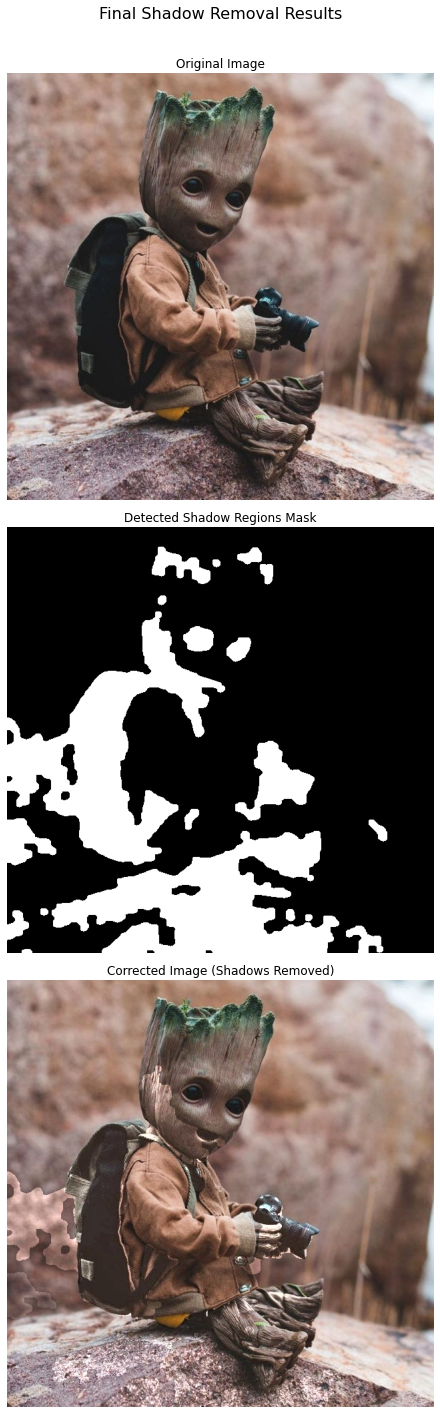

Saved result as images/photo_1_shadowClear.jpeg

Script finished.


In [12]:
image_path = os.path.join("images", "photo_1.jpeg")

if not os.path.exists("images"):
    os.makedirs("images")
if not os.path.exists(image_path):
    print(f"Warning: Test image {image_path} not found. Creating a dummy image.")
    dummy_img_data = np.zeros((300, 400, 3), dtype=np.uint8)
    cv2.rectangle(dummy_img_data, (50, 50), (150, 150), (30, 30, 30), -1) 
    cv2.rectangle(dummy_img_data, (100, 100), (300, 250), (128,128,128), -1) 
    cv2.imwrite(image_path, dummy_img_data)


org_image, mask, image_clear = process_image_file(
    image_path, 
    ab_threshold=0, 
    lab_adjustment=True, 
    save=True, 
    verbose=False 
)

print("\nScript finished.")
